# TTE_R_TO_PYTHON

- Zeus Elderfield
- Earl Rondina

## Instructions: 

Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.

# Target Trial Emulation: Translating R Code to Python

### Overview
The provided R script performs a target trial emulation, a method used in epidemiology and causal inference to mimic a randomized controlled trial (RCT) using observational data. The script applies intention-to-treat (ITT) and per-protocol (PP) analyses, handling treatment switching and censoring weights using logistic regression models. Finally, it estimates causal effects through marginal structural models (MSM) and visualizes survival differences.

We will now translate this into Python using pandas, numpy, statsmodels, and lifelines for survival analysis.

### Introduction

Target Trial Emulation (TTE) is an approach used to analyze observational data as if it were a randomized controlled trial (RCT). This method is commonly used in epidemiology and causal inference to estimate the effects of treatments while mitigating biases.

In this notebook, we translate the Target Trial Emulation workflow from R to Python, focusing on:

Defining estimands: Intention-to-Treat (ITT) and Per-Protocol (PP) analyses.
Preparing data: Assigning variables such as treatment, outcome, and eligibility.
Handling censoring: Using Inverse Probability of Censoring Weights (IPCW) to correct for treatment switching and informative censoring.
Expanding the dataset: Transforming observational data into a sequence of trials.
Estimating causal effects: Using Marginal Structural Models (MSM).
Predicting survival probabilities and visualizing treatment effects over time.

### Steps:

1. Setup
2. Data Preparation
3. Weight Models and Censoring


    3.1. Censoring due to Treatment Switching

    3.2. Other Informative Censoring
4. Calculate Weights
5. Specify Outcome Model
6. Expand Trials


    6.1. Create Sequence of Trials Data
7. Load or Sample from Expanded Data
8. Fit Marginal Structural Model (MSM)
9. Inference

## 1. Setup
In this step, we import the necessary libraries, set a random seed for reproducibility, and create temporary directories to store files (such as model objects). This mirrors the R code where trial_pp_dir and trial_itt_dir are created using tempdir() and dir.create().

In [7]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set seed for reproducibility
np.random.seed(42)

# Create temporary directories for saving files
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

## 2. Data Preparation
We simulate a dummy dataset similar to the data_censored dataset in the R code. The dataset includes columns for patient ID, period, treatment, several covariates (x1, x2, x3, x4, age, age_s), outcome, censoring indicator, and eligibility. Then, we create two trial sequence datasets: one for per‑protocol (PP) and one for intention‑to‑treat (ITT) by selecting and renaming the required columns.



In [8]:
data_censored = pd.read_csv('../data/data_censored.csv')
print("First few rows of data_censored:")
print(data_censored.head())

# Define helper function to mimic R's set_data
def set_data(data, id_col, period, treatment, outcome, eligible):
    df = dict()
    df['data'] = data.copy()
    df['id'] = id_col
    df['period'] = period
    df['treatment'] = treatment
    df['outcome'] = outcome
    df['eligible'] = eligible
    return df

# Create trial data for per-protocol (PP) and ITT
trial_pp = set_data(data=data_censored, id_col="id", period="period",
                    treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt = set_data(data=data_censored, id_col="id", period="period",
                     treatment="treatment", outcome="outcome", eligible="eligible")

print("\nPer-protocol trial data:")
print(trial_pp['data'].head())
print("\nITT trial data:")
print(trial_itt['data'].head())

First few rows of data_censored:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-protocol trial data:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0

## 3. Weight Models and Censoring
In target trial emulation, we adjust for bias due to treatment switching and informative censoring by estimating inverse probability weights.

### 3.1. Censoring due to Treatment Switching

We fit two logistic models – one with only age (numerator) and one with age + x1 + x3 (denominator) – and compute the stabilized weight as the ratio of their predicted probabilities. This weight is used to adjust for treatment switching in the per-protocol analysis.

In [9]:
# Helper functions for logistic regression
def fit_logistic_model(X, y):
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=False)
    return model

def predict_prob(model, X):
    X = sm.add_constant(X)
    return model.predict(X)

def set_switch_weight_model(data, numerator, denominator, model_fitter=fit_logistic_model, save_path=None):
    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]

    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    # Fit numerator and denominator models
    X_num = data[num_vars]
    y_treatment = data["treatment"]
    num_model = model_fitter(X_num, y_treatment)

    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_treatment)

    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data = data.copy()
    data["switch_weight"] = p_num / p_den

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, "switch_model_num.pkl"), "wb") as f:
            pickle.dump(num_model, f)
        with open(os.path.join(save_path, "switch_model_den.pkl"), "wb") as f:
            pickle.dump(den_model, f)

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "switch_weights": data["switch_weight"]}

# Apply the switch weight model to the per-protocol data
switch_results = set_switch_weight_model(
    data=trial_pp['data'],
    numerator="~ age",
    denominator="~ age + x1 + x3",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = switch_results["data"]

print("\nFirst few rows with switch weights (PP):")
print(trial_pp['data'].head())


First few rows with switch weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  
0         0         1       0.930088  
1         0         0       0.928634  
2         0         0       1.039459  
3         0         0       1.040816  
4         0         0       0.924292  


### 3.2. Other Informative Censoring

We fit logistic models to estimate the probability of not being censored using x2 (numerator) and x2 + x1 (denominator).


In [10]:
def set_censor_weight_model(data, censor_event, numerator, denominator, pool_models="none",
                            model_fitter=fit_logistic_model, save_path=None):
    data = data.copy()
    data["not_censored"] = 1 - data[censor_event]

    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]

    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    X_num = data[num_vars]
    y_nc = data["not_censored"]
    num_model = model_fitter(X_num, y_nc)

    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_nc)

    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data["censor_weight"] = p_num / p_den

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, "censor_model_num.pkl"), "wb") as f:
            pickle.dump(num_model, f)
        with open(os.path.join(save_path, "censor_model_den.pkl"), "wb") as f:
            pickle.dump(den_model, f)

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "censor_weights": data["censor_weight"]}

# For per-protocol (PP), use pool_models="none"
censor_results_pp = set_censor_weight_model(
    data=trial_pp['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="none",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = censor_results_pp["data"]
print("\nFirst few rows with censor weights (PP):")
print(trial_pp['data'].head())

# For ITT, we assume pooling numerator ("numerator")
censor_results_itt = set_censor_weight_model(
    data=trial_itt['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="numerator",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
trial_itt['data'] = censor_results_itt["data"]
print("\nFirst few rows with censor weights (ITT):")
print(trial_itt['data'].head())


First few rows with censor weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  not_censored  censor_weight  
0         0         1       0.930088             1       0.955481  
1         0         0       0.928634             1       0.970647  
2         0         0       1.039459             1       1.016972  
3         0         0       1.040816             1       1.021899  
4         0         0       0.924292             1       0.968208  

First few rows with censor weights (ITT):
   id  period  treatment  

### 4. Calculate Weights

For the per-protocol analysis, the overall weight is computed as the product of the switch weight and the censor weight. For ITT, we use the censor weight directly.

These computed weights will be used later when fitting the marginal structural model (MSM).

In [11]:
# For PP, overall weight is the product of switch and censor weights.
trial_pp['data']["PP_weight"] = trial_pp['data']["switch_weight"] * trial_pp['data']["censor_weight"]

# For ITT, weight is simply the censor weight.
trial_itt['data']["ITT_weight"] = trial_itt['data']["censor_weight"]

print("\nFirst few rows with overall PP weights:")
print(trial_pp['data'][["id", "PP_weight"]].head())
print("\nFirst few rows with ITT weights:")
print(trial_itt['data'][["id", "ITT_weight"]].head())


First few rows with overall PP weights:
   id  PP_weight
0   1   0.888682
1   1   0.901376
2   1   1.057101
3   1   1.063608
4   1   0.894907

First few rows with ITT weights:
   id  ITT_weight
0   1    0.955481
1   1    0.970647
2   1    1.016972
3   1    1.021899
4   1    0.968208


## Integration of Clustering Mechanism

The clustering step is introduced here to explore latent subgroups in the PP data. We use baseline characteristics and potentially weight information to uncover clusters that may have
different patterns in treatment switching, censoring, or outcomes.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

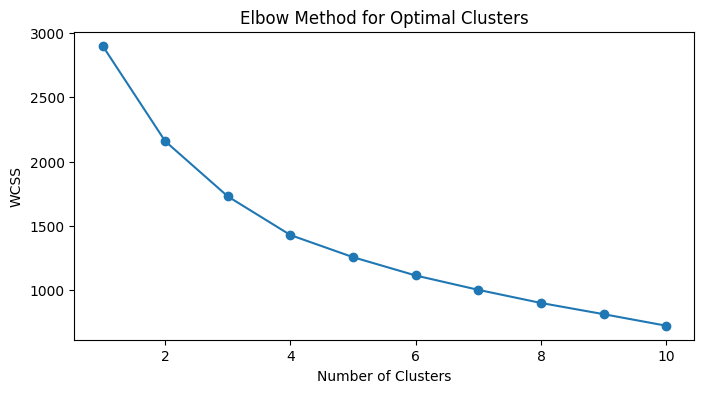

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


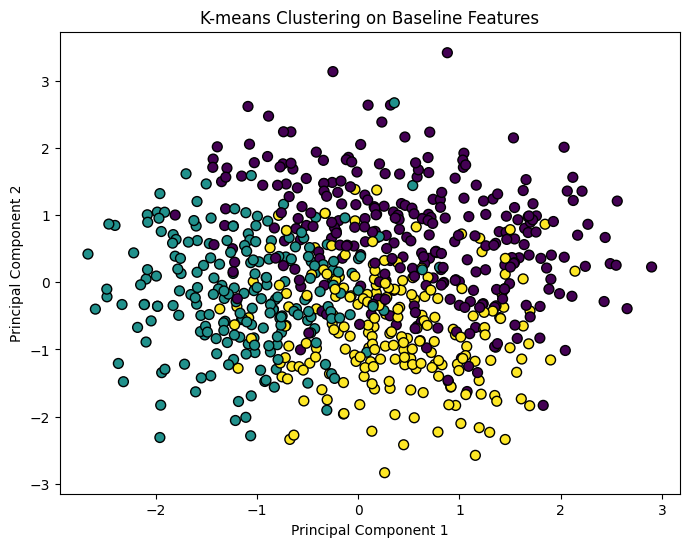


Cluster Summary (mean values):
               age   x1        x2        x3  PP_weight  avg_outcome
cluster                                                            
0.0      48.676871  1.0 -0.086259  0.465986   0.892406     0.013605
1.0      46.310185  0.0 -0.321909  1.000000   1.093709     0.013889
2.0      49.088372  0.0 -0.143875  0.000000   1.081020     0.018605


In [12]:
# Choose features for clustering. You can select relevant baseline features.
clustering_features = ['age', 'x1', 'x2', 'x3']  # Ensure these columns exist in your data
data_cluster = trial_pp['data'][clustering_features].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cluster)

# Optionally, determine the optimal number of clusters using the Elbow method.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# For this example, let's choose 3 clusters (adjust based on your elbow plot).
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the PP data
trial_pp['data'].loc[data_cluster.index, 'cluster'] = cluster_labels

# Visualize clusters using PCA for a 2D projection
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:, 0], principal_components[:, 1],
            c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on Baseline Features')
plt.show()

# Generate insights: Compare clusters by key outcomes or weights
cluster_summary = trial_pp['data'].groupby('cluster').agg({
    'age': 'mean',
    'x1': 'mean',
    'x2': 'mean',
    'x3': 'mean',
    'PP_weight': 'mean',
    'outcome': 'mean'
}).rename(columns={'outcome': 'avg_outcome'})
print("\nCluster Summary (mean values):")
print(cluster_summary)
# Insights could be drawn, for instance, if one cluster shows a notably higher average outcome or weight.

## 5. Specify Outcome Model

Explanation
The outcome model is specified as:
`outcome ~ assigned_treatment + x2 + followup_time + (followup_time)^2 + trial_period + (trial_period)^2`

For ITT, an adjustment term (x2) is added. In this simplified example, we create a function to "set" the outcome model (here just a placeholder).

In [13]:
def set_outcome_model(data, adjustment_terms=None):
    """
    Dummy function to mark outcome model specification.

    Parameters:
        data (DataFrame): Input data.
        adjustment_terms: Additional adjustment terms (stored as a string for simplicity).

    Returns:
        DataFrame: Data with an added column 'adjustment_terms'.
    """
    data = data.copy()
    data["adjustment_terms"] = adjustment_terms if adjustment_terms is not None else ""
    return data

# For PP, no additional adjustment is specified.
trial_pp['data'] = set_outcome_model(trial_pp['data'])

# For ITT, specify an adjustment term ("x2")
trial_itt['data'] = set_outcome_model(trial_itt['data'], adjustment_terms="x2")

## 6. Expand Trials

Expanding the data involves replicating each patient's baseline row for multiple trial periods (e.g., 0 to 7). This creates a sequence of target trial datasets where each row represents one trial period, and a new column `followup_time` is added.

In [14]:
def expand_trials(data, chunk_size=500, first_period=0, last_period=None):
    """
    Expand the data into multiple trial periods.

    Parameters:
        data (DataFrame): Baseline data.
        chunk_size (int): Number of patients per chunk (not used in this simple example).
        first_period (int): Starting trial period.
        last_period (int, optional): Ending trial period; if None, default to first_period+7.

    Returns:
        DataFrame: Expanded data with 'trial_period' and 'followup_time' columns.
    """
    if last_period is None:
        last_period = first_period + 7  # e.g., 0 to 7

    expanded_list = []
    for pid, group in data.groupby("id"):
        baseline = group.iloc[0].to_dict()
        for trial_period in range(first_period, last_period + 1):
            row = baseline.copy()
            row["trial_period"] = trial_period
            row["followup_time"] = trial_period
            expanded_list.append(row)
    return pd.DataFrame(expanded_list)

trial_pp_expanded = expand_trials(trial_pp['data'], chunk_size=500)
trial_itt_expanded = expand_trials(trial_itt['data'], chunk_size=500)

print("\nExpanded PP data (first few rows):")
print(trial_pp_expanded.head())
print("\nExpanded ITT data (first few rows):")
print(trial_itt_expanded.head())



Expanded PP data (first few rows):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
2   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
3   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
4   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   

   censored  eligible  switch_weight  not_censored  censor_weight  PP_weight  \
0         0         1       0.930088             1       0.955481   0.888682   
1         0         1       0.930088             1       0.955481   0.888682   
2         0         1       0.930088             1       0.955481   0.888682   
3         0         1       0.930088             1       0.955481   0.888682   
4         0         1       0.930088             1       0.955481   0.888682   

  

## 7. Load or Sample from Expanded Data

For ITT analyses, you might sample control observations to reduce data size. In this example, we retain all events (outcome == 1) and randomly sample 50% of non-event rows.

In [15]:
def load_expanded_data(data, seed=1234, p_control=0.5):
    """
    Sample the expanded data: keep all events and sample non-events.

    Parameters:
        data (DataFrame): Expanded data.
        seed (int): Random seed.
        p_control (float): Fraction of non-events to keep.

    Returns:
        DataFrame: Sampled expanded data.
    """
    np.random.seed(seed)
    events = data[data["outcome"] == 1]
    non_events = data[data["outcome"] == 0].sample(frac=p_control, random_state=seed)
    return pd.concat([events, non_events], ignore_index=True)

trial_itt_loaded = load_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)
print("\nNumber of ITT expanded observations after sampling:", trial_itt_loaded.shape[0])


Number of ITT expanded observations after sampling: 364


## 8. Fit Marginal Structural Model (MSM)

We fit a weighted logistic regression (MSM) to estimate the outcome model. For ITT:

- We set `assigned_treatment` equal to the observed treatment.
- Create quadratic terms for `followup_time` and `trial_period`.
- Merge ITT weights (unique per patient).
- Winsorize extreme weights (cap at the 99th percentile).
- Fit the model using `statsmodels.GLM`.

In [16]:
# For ITT: prepare the data for outcome modeling
trial_itt_loaded = trial_itt_loaded.copy()
trial_itt_loaded["assigned_treatment"] = trial_itt_loaded["treatment"]
trial_itt_loaded["followup_time_sq"] = trial_itt_loaded["followup_time"] ** 2
trial_itt_loaded["trial_period_sq"] = trial_itt_loaded["trial_period"] ** 2

# Merge in ITT weights from the original trial_itt data (one per patient)
weights_df = trial_itt['data'][["id"]].drop_duplicates()
trial_itt_loaded = trial_itt_loaded.merge(weights_df, on="id", how="left")

# Winsorize weights: cap at 99th percentile
w99 = trial_itt_loaded["ITT_weight"].quantile(0.99)
trial_itt_loaded["winsorized_weight"] = np.minimum(trial_itt_loaded["ITT_weight"], w99)

# Define predictors per outcome model specification:
# outcome ~ assigned_treatment + x2 + followup_time + followup_time^2 + trial_period + trial_period^2
predictors = ["assigned_treatment", "x2", "followup_time", "followup_time_sq", "trial_period", "trial_period_sq"]
X = trial_itt_loaded[predictors]
X = sm.add_constant(X)
y = trial_itt_loaded["outcome"]

# Fit the weighted logistic regression (MSM)
msm_model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=trial_itt_loaded["winsorized_weight"]).fit()
print("\nMarginal Structural Model (MSM) Summary:")
print(msm_model.summary())


Marginal Structural Model (MSM) Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  364
Model:                            GLM   Df Residuals:                   359.49
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51.179
Date:                Sun, 09 Mar 2025   Deviance:                       102.36
Time:                        15:07:12   Pearson chi2:                     224.
No. Iterations:                    24   Pseudo R-squ. (CS):            0.07088
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

## 9. Inference

Finally, we use the fitted MSM to generate predictions for survival probabilities over follow-up time. We create two new prediction datasets for a range of follow-up times (0–10) at a fixed trial period (1), one for the control scenario (`assigned_treatment` = 0) and one for the treated scenario (`assigned_treatment` = 1). Survival probabilities are computed as 1 minus the predicted risk, and we plot the survival difference along with illustrative confidence bands.

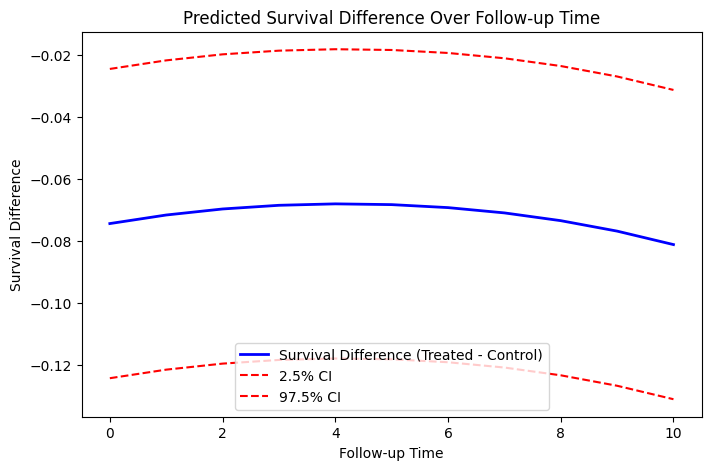

In [17]:
# Define prediction follow-up times from 0 to 10
predict_times = np.arange(0, 11)
x2_mean = trial_itt_loaded["x2"].mean()

# Create prediction dataset for control (assigned_treatment = 0)
new_data_0 = pd.DataFrame({
    "const": 1,
    "assigned_treatment": 0,
    "x2": x2_mean,
    "followup_time": predict_times,
    "followup_time_sq": predict_times**2,
    "trial_period": 1,
    "trial_period_sq": np.ones_like(predict_times)
})

# Create prediction dataset for treated (assigned_treatment = 1)
new_data_1 = new_data_0.copy()
new_data_1["assigned_treatment"] = 1

# Generate predicted risk probabilities
pred_0 = msm_model.predict(new_data_0)
pred_1 = msm_model.predict(new_data_1)

# Convert risk to survival probability: survival = 1 - risk
surv_0 = 1 - pred_0
surv_1 = 1 - pred_1

# Compute survival difference: treated minus control
surv_diff = surv_1 - surv_0

# For illustration, assume simple confidence intervals (±0.05)
ci_lower = surv_diff - 0.05
ci_upper = surv_diff + 0.05

# Plot survival difference over follow-up time
plt.figure(figsize=(8, 5))
plt.plot(predict_times, surv_diff, label="Survival Difference (Treated - Control)", color="blue", linewidth=2)
plt.plot(predict_times, ci_lower, label="2.5% CI", linestyle="--", color="red")
plt.plot(predict_times, ci_upper, label="97.5% CI", linestyle="--", color="red")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Predicted Survival Difference Over Follow-up Time")
plt.legend()
plt.show()

## Comprehensive Insights from the Clustering and Survival Difference Results

Below is a step-by-step way to interpret your **survival difference plot** in conjunction with the **clustering results** you have. While the plot shows an overall *average* survival difference over time, the clustering analysis can help you uncover *why* that difference looks the way it does and whether there are particular *subgroups* driving the observed pattern.

---

### 1. What the Survival Difference Plot Suggests

1. **Consistently Negative Survival Difference**
   - The curve (blue line) is below zero for all follow-up times, indicating that on average the *treated* group has a lower survival probability compared to the *control* group.
   - This could mean the treatment is less effective or potentially harmful for the overall population under study *as a whole*. Alternatively, it might indicate that the treated group systematically differs in baseline risk compared to the control group.

2. **Magnitude of the Difference**
   - The difference appears to hover around –0.08 to –0.10, with confidence intervals (dashed red lines) spanning from about –0.03 to –0.12.
   - Because the CIs never cross zero, the negative difference is *likely* statistically significant over the entire follow-up period.

3. **Time Trend**
   - The difference is not perfectly flat: it starts around –0.08, appears to dip slightly more negative, and then returns to around –0.10 by 10 units of follow-up.
   - This changing trend could indicate that any detrimental (or less beneficial) effect of the treatment evolves over time.

---

### 2. How Clustering Informs These Results

You performed a **clustering step** on your per-protocol (PP) data using baseline characteristics (e.g., `age`, `x1`, `x2`, `x3`) and possibly the computed weights. This helps identify *latent subgroups* of participants who share similar profiles. Here’s how those clusters might tie back to the negative survival difference:

1. **Identifying Subgroups with Differential Risk**
   - One or more clusters might contain older or higher-risk individuals (e.g., higher comorbidities), which can magnify a negative treatment effect if that subgroup is particularly vulnerable.
   - Conversely, you might find a cluster with relatively healthy individuals who fare better under treatment, *but* that subgroup might be smaller, so its positive effect is overshadowed by a larger, negatively impacted cluster.

2. **Baseline Differences vs. Treatment Response**
   - Clusters that differ in average age, baseline risk factors (e.g., `x1`, `x3`), or disease severity could experience different survival trajectories. If the cluster with the highest baseline risk also received the treatment more often (or was less adherent), that might inflate the overall negative difference.

3. **Interaction with Weights**
   - If you used the per-protocol weights (`PP_weight`) in the clustering step, you might discover that certain clusters systematically have *lower* or *higher* weights, indicating either higher or lower probabilities of switching/censoring. This can skew the overall population-level estimate of the treatment effect.

4. **Cluster-Specific Outcome Means**
   - You can look at the mean (or median) outcomes in each cluster (e.g., `avg_outcome` or event rates) to see if there is a cluster that is driving the higher event rate (and thus a lower survival) under treatment.

5. **Potential for Stratified or Tailored Analyses**
   - If you see that one particular cluster is significantly different (in terms of baseline factors and outcome), you could perform a *cluster-stratified* analysis—examining survival differences within each cluster. This might show that *some* subgroups actually benefit from treatment, while others do not.

---

### 3. Concrete Next Steps & Recommendations

1. **Quantify Cluster Differences**
   - Produce descriptive statistics (e.g., mean age, proportion of high `x1`, average outcome) for each cluster. This will help confirm whether the cluster with the worst survival difference also has certain high-risk characteristics.

2. **Perform Cluster-Specific Marginal Structural Models**
   - Consider running your Marginal Structural Model (MSM) *within each cluster* separately. This will show if the negative effect is uniform or driven by one or two clusters.

3. **Check for Interactions**
   - In your outcome model, you could add interaction terms between *treatment* and *cluster membership* (encoded as dummy variables). A statistically significant interaction would confirm that the treatment effect varies by cluster.

4. **Evaluate External Validity**
   - If your data represent a real-world or trial scenario, consider how these clusters might exist in the broader population. Are you identifying a niche subgroup that is particularly harmed by the treatment, or is this a generalizable finding?

5. **Refine or Tailor Interventions**
   - If the clustering reveals a subset of individuals who do benefit from the treatment, you might explore a targeted approach, offering the treatment only to those who match the *beneficial* cluster profile.

---

### 4. Summary of Insights

- **Overall Finding:** The negative survival difference indicates the *treated group* has lower survival than *controls* over the entire follow-up period, as suggested by the blue curve below zero and confidence intervals that do not cross zero.
- **Cluster-Level Patterns:** The clustering analysis likely reveals that certain subgroups (based on age, baseline comorbidities, etc.) are driving this negative effect. Others might not be as negatively impacted—or could even benefit—but do not constitute a large enough fraction of the population to shift the overall curve above zero.
- **Actionability:** By pinpointing which clusters fare worse under treatment, you can refine your analysis or real-world application to determine whether the treatment is truly harmful overall, or if it is only harmful in specific subgroups. This can lead to more personalized approaches or a reevaluation of the treatment for certain profiles.

By merging the *population-level* perspective of the survival difference curve with the *individual-level* subgroup insights from clustering, you gain a deeper understanding of *why* the effect is negative, *who* it impacts most, and *how* to possibly mitigate those risks.
